In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [3]:
trips = pq.read_table('yellow_tripdata_2024-01.parquet')
df_jan = trips.to_pandas()

In [4]:
del trips

In [5]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [6]:
df_jan.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [7]:
# Cast columns
df_jan['tpep_pickup_datetime'] = pd.to_datetime(df_jan['tpep_pickup_datetime'], errors='coerce')
df_jan['tpep_dropoff_datetime'] = pd.to_datetime(df_jan['tpep_dropoff_datetime'], errors='coerce')
df_jan["passenger_count"] = pd.to_numeric(df_jan["passenger_count"], downcast="integer", errors="coerce")
df_jan["trip_distance"] = pd.to_numeric(df_jan["trip_distance"], errors="coerce")
df_jan["RatecodeID"] = pd.to_numeric(df_jan["RatecodeID"], downcast="integer", errors="coerce")
df_jan["PULocationID"] = pd.to_numeric(df_jan["PULocationID"], downcast="integer", errors="coerce")
df_jan["DOLocationID"] = pd.to_numeric(df_jan["DOLocationID"], downcast="integer", errors="coerce")
df_jan["payment_type"] = pd.to_numeric(df_jan["payment_type"], downcast="integer", errors="coerce")
df_jan["fare_amount"] = pd.to_numeric(df_jan["fare_amount"], errors="coerce")
df_jan["extra"] = pd.to_numeric(df_jan["extra"], errors="coerce")
df_jan["mta_tax"] = pd.to_numeric(df_jan["mta_tax"], errors="coerce")
df_jan["tip_amount"] = pd.to_numeric(df_jan["tip_amount"], errors="coerce")
df_jan["tolls_amount"] = pd.to_numeric(df_jan["tolls_amount"], errors="coerce")
df_jan["improvement_surcharge"] = pd.to_numeric(df_jan["improvement_surcharge"], errors="coerce")
df_jan["total_amount"] = pd.to_numeric(df_jan["total_amount"], errors="coerce")
df_jan["congestion_surcharge"] = pd.to_numeric(df_jan["congestion_surcharge"], errors="coerce")
df_jan["Airport_fee"] = pd.to_numeric(df_jan["Airport_fee"], errors="coerce")

In [8]:
df_jan.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [9]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int16         
 8   DOLocationID           int16         
 9   payment_type           int8          
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [10]:
# Trip journey in hours
df_jan['journey_duration_in_hrs'] = (df_jan['tpep_dropoff_datetime'] - df_jan['tpep_pickup_datetime']).dt.total_seconds() / 3600.0

In [11]:
df_jan.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,journey_duration_in_hrs
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0,0.330000
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,0.110000
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0,0.298611
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0,0.138333
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0,0.101667


# Aggregating Hours for Entire Month altogether

In [12]:
# Just summarize how many trips
df_agg = df_jan[["tpep_pickup_datetime"]].copy()
df_agg.head(5) 

,tpep_pickup_datetime
0,2024-01-01 00:57:55
1,2024-01-01 00:03:00
2,2024-01-01 00:17:06
3,2024-01-01 00:36:38
4,2024-01-01 00:46:51


In [13]:
df_agg["hour"] = df_agg["tpep_pickup_datetime"].dt.hour
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 2 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[us]
 1   hour                  int32         
dtypes: datetime64[us](1), int32(1)
memory usage: 33.9 MB


In [14]:
df_agg.tail(5)

,tpep_pickup_datetime,hour
2964619,2024-01-31 23:45:59,23
2964620,2024-01-31 23:13:07,23
2964621,2024-01-31 23:19:00,23
2964622,2024-01-31 23:07:23,23
2964623,2024-01-31 23:58:25,23


In [15]:
df_agg["hour"].unique()

array([ 0, 23,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 22, 19, 20, 21], dtype=int32)

In [16]:
# Aggregate by hour
df_trip_counts_in_hour = df_agg.groupby("hour").size().reset_index(name="trip_counts")

In [17]:
df_trip_counts_in_hour.head(5)

,hour,trip_counts
0,0,79094
1,1,53627
2,2,37517
3,3,24811
4,4,16742


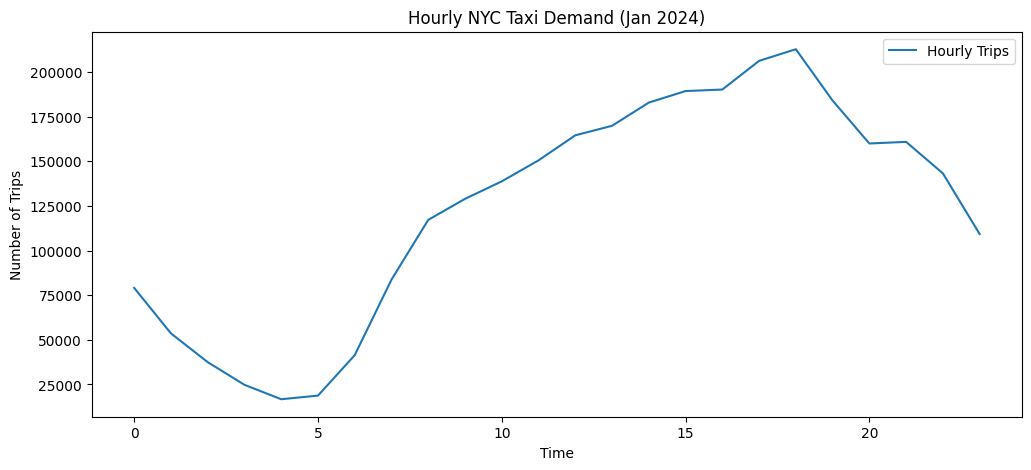

In [18]:
# Plot hourly demand
plt.figure(figsize=(12, 5))
plt.plot(df_trip_counts_in_hour["hour"].to_numpy(), df_trip_counts_in_hour["trip_counts"].to_numpy(), label="Hourly Trips")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title("Hourly NYC Taxi Demand (Jan 2024)")
plt.legend()
plt.show()

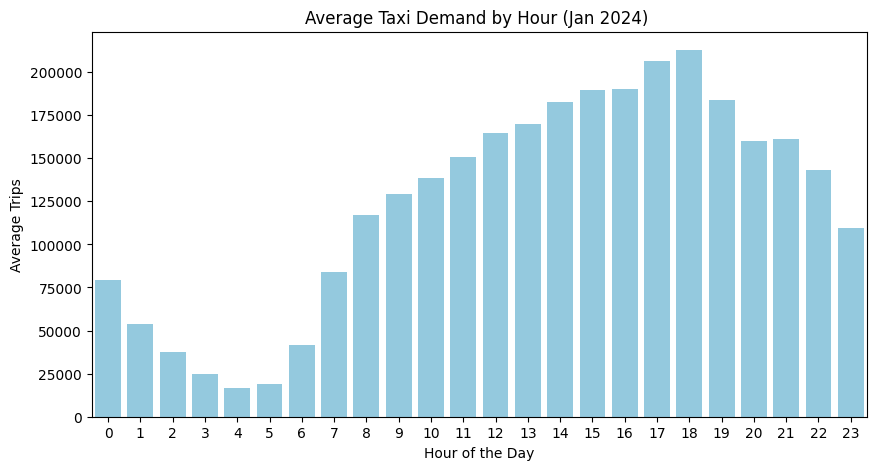

In [19]:
# Plot demand pattern by hour of the day
plt.figure(figsize=(10, 5))
sns.barplot(x=df_trip_counts_in_hour["hour"].to_numpy(), y=df_trip_counts_in_hour["trip_counts"].to_numpy(), color="skyblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Trips")
plt.title("Average Taxi Demand by Hour (Jan 2024) ")
plt.show()


In [20]:
df_trip_counts_in_hour["trip_counts"]

0      79094
1      53627
2      37517
3      24811
4      16742
5      18764
6      41429
7      83719
8     117209
9     128970
10    138778
11    150542
12    164559
13    169903
14    182898
15    189359
16    190201
17    206257
18    212788
19    184032
20    159989
21    160888
22    143261
23    109287
Name: trip_counts, dtype: int64

In [21]:
# Train SARIMA model
sarima_model = SARIMAX(df_trip_counts_in_hour["trip_counts"].to_numpy(), order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_result = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/shaukat/virtualenv/dev/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/shaukat/virtualenv/dev/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


# Daily One-Hour Block

In [57]:
# Lets just get Jan 2024
df_agg = df_jan[["tpep_pickup_datetime"]].copy()
print(len(df_agg))
df_agg = df_agg.loc[df_agg["tpep_pickup_datetime"] > "2023-12-31 23:59:59"]
df_agg.reset_index(drop=True, inplace=True)
print(len(df_agg))

2964624
2964609


In [58]:
print(df_agg["tpep_pickup_datetime"].min(), df_agg["tpep_pickup_datetime"].max())

2024-01-01 00:00:00 2024-02-01 00:01:15


In [61]:
# df_agg = df_jan[["tpep_pickup_datetime"]].copy()
df_agg["date"] = df_agg["tpep_pickup_datetime"].dt.date.astype(str)
df_agg["hour"] = df_agg["tpep_pickup_datetime"].dt.hour.astype(str)
df_agg.tail(5)

,tpep_pickup_datetime,date,hour
2964604,2024-01-31 23:45:59,2024-01-31,23
2964605,2024-01-31 23:13:07,2024-01-31,23
2964606,2024-01-31 23:19:00,2024-01-31,23
2964607,2024-01-31 23:07:23,2024-01-31,23
2964608,2024-01-31 23:58:25,2024-01-31,23


In [62]:
print(df_agg["tpep_pickup_datetime"].min(), df_agg["tpep_pickup_datetime"].max())

2024-01-01 00:00:00 2024-02-01 00:01:15


In [63]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964609 entries, 0 to 2964608
Data columns (total 3 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[us]
 1   date                  object        
 2   hour                  object        
dtypes: datetime64[us](1), object(2)
memory usage: 67.9+ MB


In [64]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964609 entries, 0 to 2964608
Data columns (total 3 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[us]
 1   date                  object        
 2   hour                  object        
dtypes: datetime64[us](1), object(2)
memory usage: 67.9+ MB


In [65]:
# Groupby
df_agg = df_agg.groupby(["date", "hour"]).size().reset_index(name="daily_hourly_tripcounts")
# df_agg["date_hour"] = str(df_agg["date"]) + '_' + df_agg["hour"].astype(str)
df_agg.tail(5)

,date,hour,daily_hourly_tripcounts
740,2024-01-31,6,1582
741,2024-01-31,7,3647
742,2024-01-31,8,5244
743,2024-01-31,9,5333
744,2024-02-01,0,3


In [66]:
df_agg["date_hour"] = df_agg["date"] + '_' + df_agg["hour"]

In [68]:
df_agg.tail(5)

,date,hour,daily_hourly_tripcounts,date_hour
740,2024-01-31,6,1582,2024-01-31_6
741,2024-01-31,7,3647,2024-01-31_7
742,2024-01-31,8,5244,2024-01-31_8
743,2024-01-31,9,5333,2024-01-31_9
744,2024-02-01,0,3,2024-02-01_0


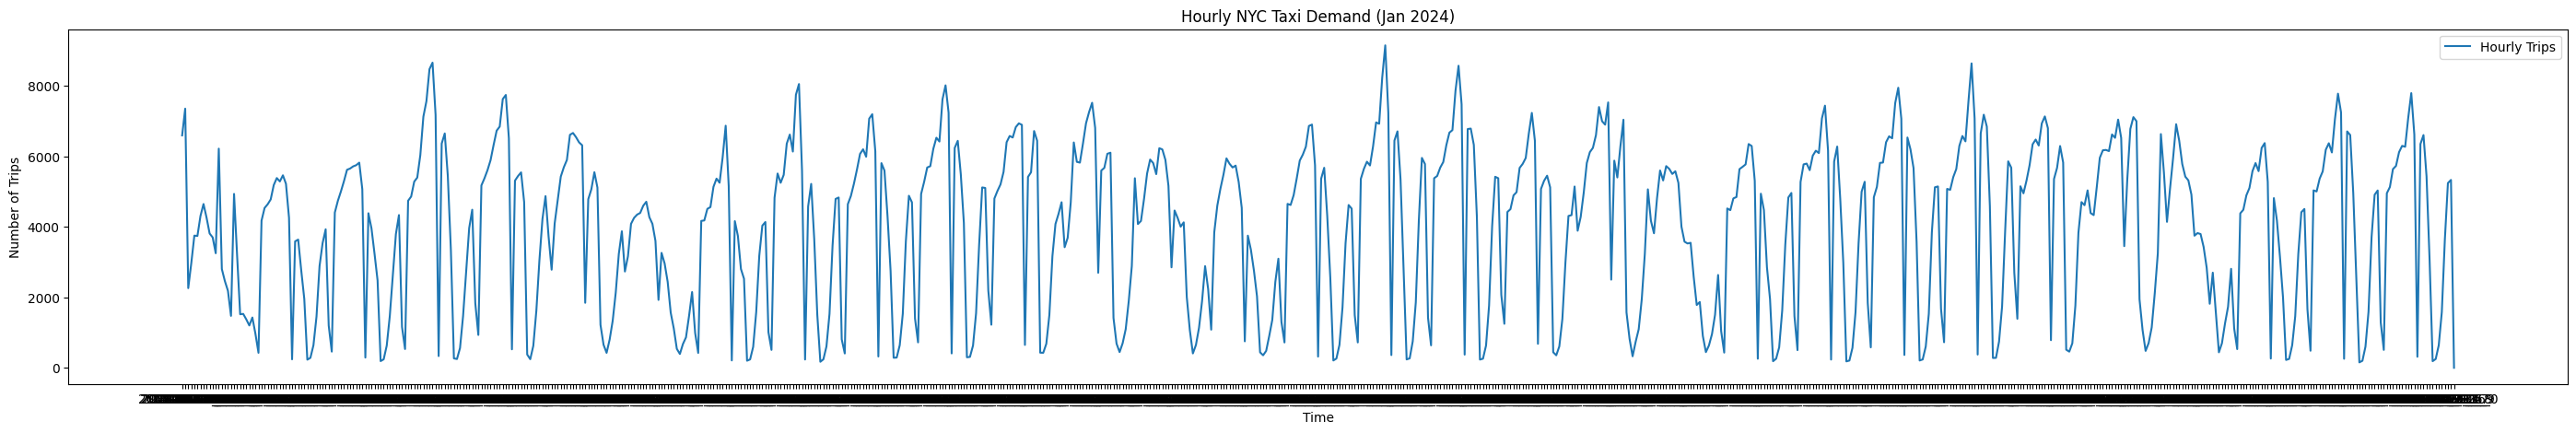

In [71]:
# Plot hourly demand
plt.figure(figsize=(35, 5))
plt.plot(df_agg["date_hour"].to_numpy(), df_agg["daily_hourly_tripcounts"].to_numpy(), label="Hourly Trips")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title("Hourly NYC Taxi Demand (Jan 2024)")
plt.legend()
plt.show()

In [72]:
# Convert 'date_hour' column to datetime
df_agg['datetime'] = pd.to_datetime(df_agg['date_hour'].str.replace('_', ' '), format='%Y-%m-%d %H')
df_agg

,date,hour,daily_hourly_tripcounts,date_hour,datetime
0,2024-01-01,0,6596,2024-01-01_0,2024-01-01 00:00:00
1,2024-01-01,1,7355,2024-01-01_1,2024-01-01 01:00:00
2,2024-01-01,10,2263,2024-01-01_10,2024-01-01 10:00:00
3,2024-01-01,11,2974,2024-01-01_11,2024-01-01 11:00:00
4,2024-01-01,12,3753,2024-01-01_12,2024-01-01 12:00:00
...,...,...,...,...,...
740,2024-01-31,6,1582,2024-01-31_6,2024-01-31 06:00:00
741,2024-01-31,7,3647,2024-01-31_7,2024-01-31 07:00:00
742,2024-01-31,8,5244,2024-01-31_8,2024-01-31 08:00:00
743,2024-01-31,9,5333,2024-01-31_9,2024-01-31 09:00:00


In [81]:
# Define the hour for which labels should be displayed
selected_hour = 17  

# Set x-axis labels: only show the selected hour, others remain empty
filtered_labels = [d.strftime('%Y-%m-%d_%H') if d.hour == selected_hour else "" for d in df_agg['datetime']]


In [82]:
filtered_labels

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-01_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-02_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-03_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-04_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-05_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-06_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-07_17',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024-01-08_17',
 '',
 

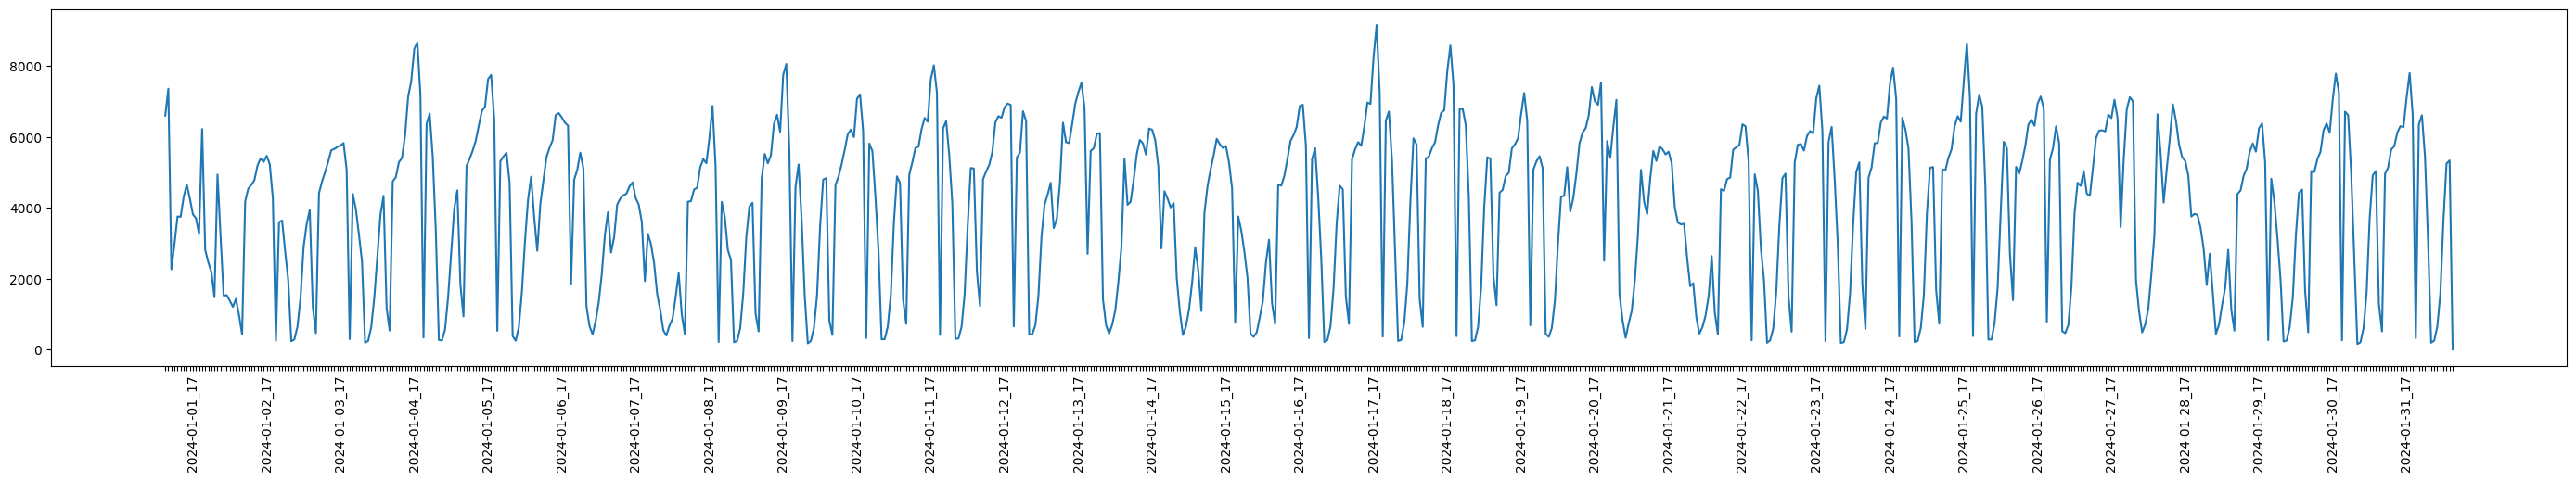

In [84]:
# Plot
fig, ax = plt.subplots(figsize=(35, 5))
ax.plot(df_agg["date_hour"].to_numpy(), df_agg["daily_hourly_tripcounts"].to_numpy())

# Apply the modified x-axis labels
ax.set_xticks(df_agg['date_hour'])
ax.set_xticklabels(filtered_labels, rotation=90, ha='center')

# Show the plot
plt.show()

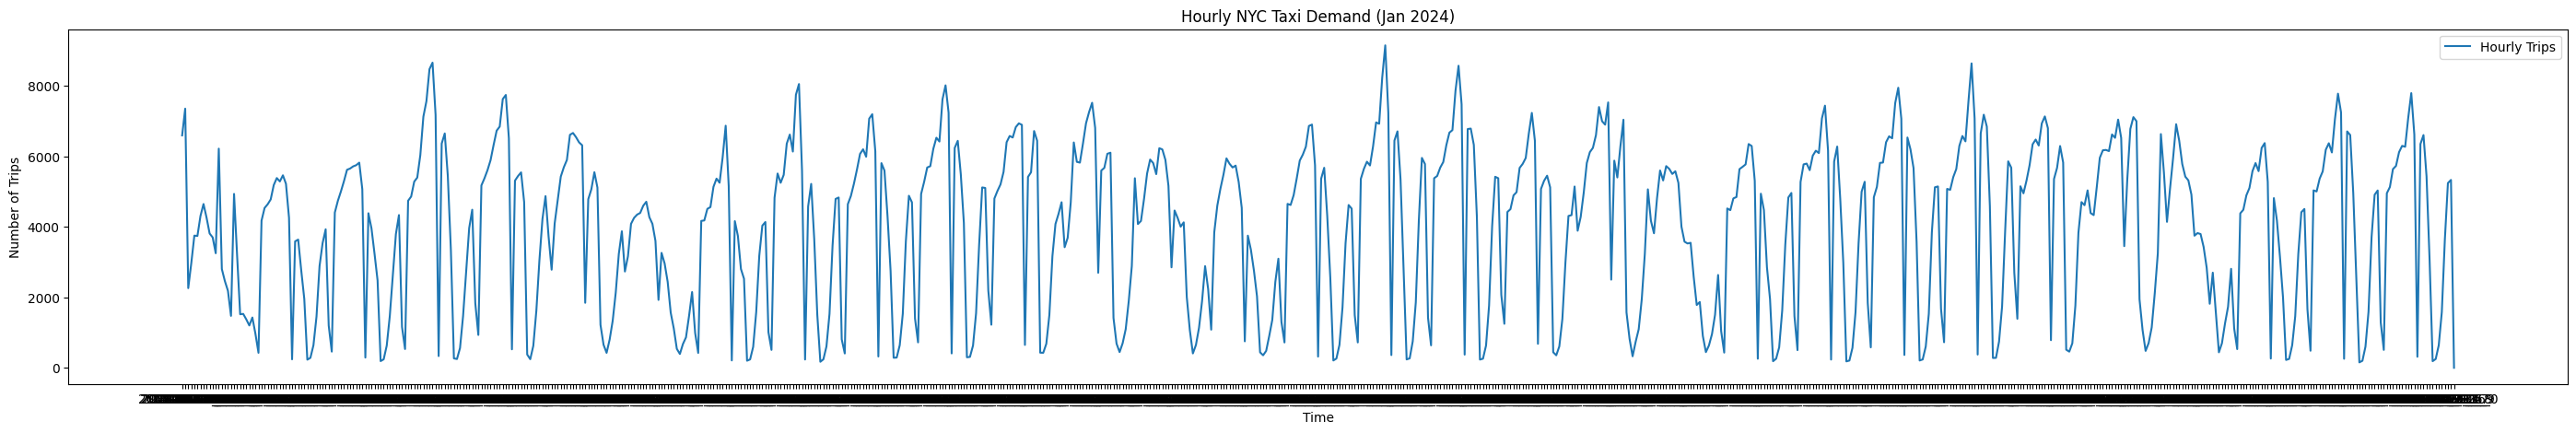

In [77]:
# Plot hourly demand
plt.figure(figsize=(35, 5))
plt.plot(df_agg["date_hour"].to_numpy(), df_agg["daily_hourly_tripcounts"].to_numpy(), label="Hourly Trips")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title("Hourly NYC Taxi Demand (Jan 2024)")
plt.legend()
plt.show()